In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.base import clone

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import auc, roc_curve

import time

In [3]:
file_path = "../data/uci-secom.csv"
df = pd.read_csv(file_path)

df['Pass/Fail'] = df['Pass/Fail'].replace({1: 0, -1: 1}) # Pass = 1 , Fail = 0

print("Data shape:", df.shape)
print(df['Pass/Fail'].value_counts())
df.head()

Data shape: (1567, 592)
Pass/Fail
1    1463
0     104
Name: count, dtype: int64


,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,0
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,1


In [ ]:
parquet_file = "../data/uci-secom.parquet"
df.to_parquet(parquet_file, engine='pyarrow', index=False)  

print(f"Converted to: {parquet_file}")

df_parquet = pd.read_parquet(parquet_file, engine='pyarrow')

df_parquet.head()

Converted to: ../data/uci-secom.parquet


,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,0
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,1


In [ ]:
df.describe().T

In [ ]:
df.info()

In [ ]:
df['Pass/Fail'].value_counts().plot.bar()

In [ ]:
nan_percentage = df.isna().mean() * 100

bins = list(range(0, 110, 10))
labels = [f"{i}-{i+10}%" for i in bins[:-1]]
binned = pd.cut(nan_percentage, bins=bins, labels=labels, right=False)

nan_distribution = binned.value_counts().sort_index()

print(nan_distribution)

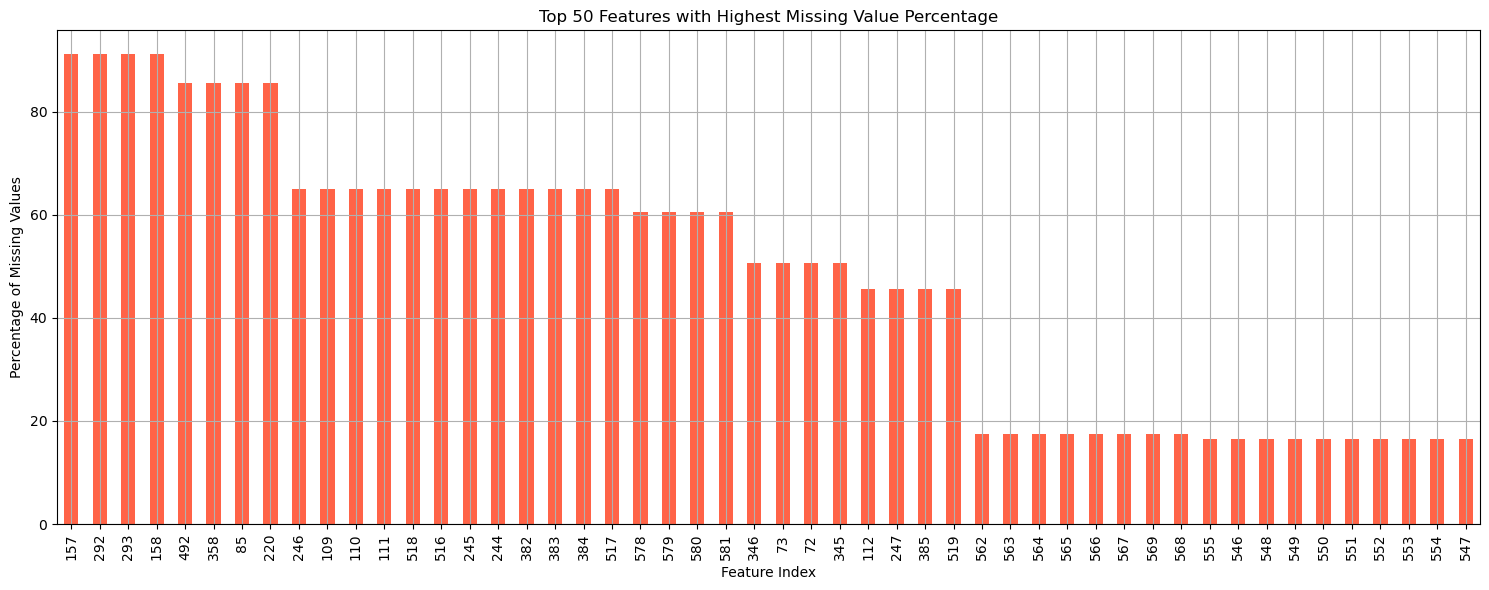


Number of columns with > 50% NaNs: 28


In [4]:
features_only = df.drop(columns=['Pass/Fail', 'Time'])
missing_percent = features_only.isnull().mean() * 100
missing_percent = missing_percent.sort_values(ascending=False)

plt.figure(figsize=(15, 6))
missing_percent[:50].plot(kind='bar', color='tomato')
plt.title("Top 50 Features with Highest Missing Value Percentage")
plt.ylabel("Percentage of Missing Values")
plt.xlabel("Feature Index")
plt.grid(True)
plt.tight_layout()
plt.show()

high_nan_columns = missing_percent[missing_percent > 50]
print(f"\nNumber of columns with > 50% NaNs: {len(high_nan_columns)}")


In [5]:
X = df.drop(columns=['Pass/Fail', 'Time'], errors='ignore')
y = df['Pass/Fail'].values

# Apply rolling median per column to fill missing values
# Window size: 11 (5 before + 5 after + current)
window_size = 11
X_rolled = X.copy()

for col in X_rolled.columns:
    if X_rolled[col].isna().any():
        X_rolled[col] = X_rolled[col].fillna(
            X_rolled[col].rolling(window=window_size, center=True, min_periods=1).median()
        )

# Fill any remaining NaNs (e.g. at edges) using column median as fallback
X_rolled = X_rolled.fillna(X_rolled.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rolled)


In [6]:
# Train ExtraTreesClassifier
et_model = ExtraTreesClassifier(n_estimators=300, random_state=42)
et_model.fit(X_scaled, y)

et_importances = et_model.feature_importances_

# Save to DataFrame
importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': et_importances
}).sort_values(by='importance', ascending=False)


In [7]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
rf_model.fit(X_scaled, y)

rf_importances = rf_model.feature_importances_

# Create DataFrame
rf_importances_df = pd.DataFrame({
    'feature': X.columns,
    'rf_importance': rf_importances
}).sort_values(by='rf_importance', ascending=False)


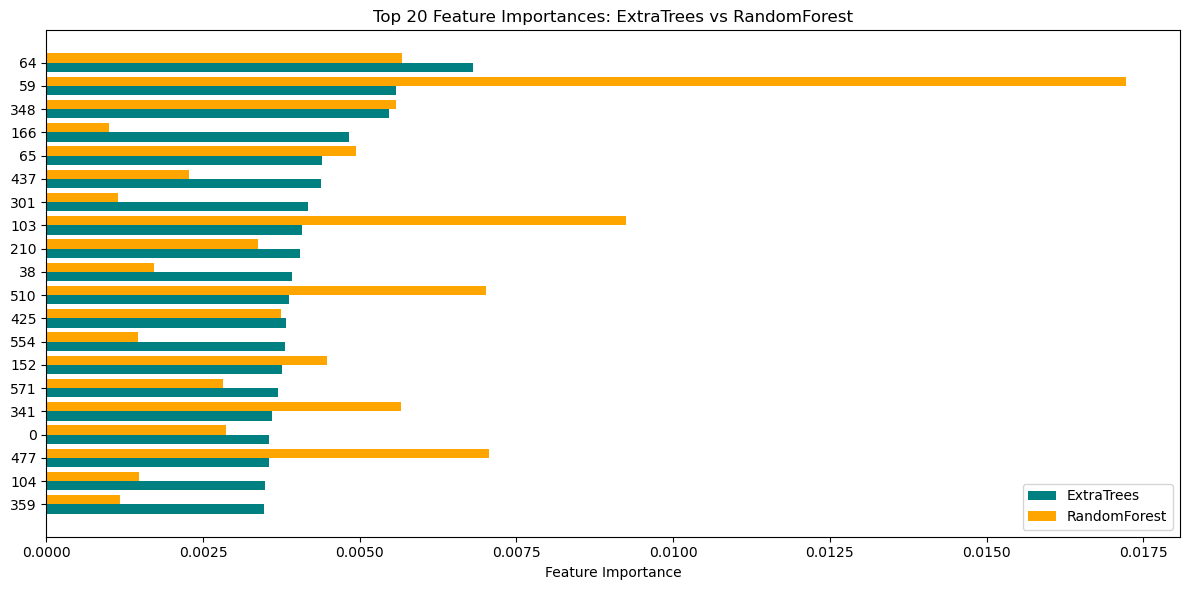

In [8]:
# Merge with ExtraTrees importances
merged_importances = importances_df.merge(rf_importances_df, on='feature')

# Plot both side by side
top_n = 20
top_features = merged_importances.head(top_n)

plt.figure(figsize=(12, 6))
bar_width = 0.4
indices = range(top_n)

plt.barh([i + bar_width for i in indices], top_features['importance'], height=bar_width, label='ExtraTrees', color='teal')
plt.barh(indices, top_features['rf_importance'], height=bar_width, label='RandomForest', color='orange')
plt.yticks([i + bar_width/2 for i in indices], top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances: ExtraTrees vs RandomForest')
plt.legend()
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


In [9]:
# === From ExtraTrees ===
threshold_et = 0.90  # Keep features that explain 90% of total importance
et_cum_importance = importances_df['importance'].cumsum()
et_selected_features = importances_df[et_cum_importance <= threshold_et]['feature'].tolist()

# Create reduced feature DataFrame for ExtraTrees
X_et = X_scaled[:, [X.columns.get_loc(feat) for feat in et_selected_features]]
et_df = pd.DataFrame(X_et, columns=et_selected_features)
et_df['Pass/Fail'] = y

print(f"ExtraTrees selected {len(et_selected_features)} features.")

# === From RandomForest ===
threshold_rf = 0.90
rf_cum_importance = rf_importances_df['rf_importance'].cumsum()
rf_selected_features = rf_importances_df[rf_cum_importance <= threshold_rf]['feature'].tolist()

# Create reduced feature DataFrame for RandomForest
X_rf = X_scaled[:, [X.columns.get_loc(feat) for feat in rf_selected_features]]
rf_df = pd.DataFrame(X_rf, columns=rf_selected_features)
rf_df['Pass/Fail'] = y

print(f"RandomForest selected {len(rf_selected_features)} features.")

ExtraTrees selected 391 features.
RandomForest selected 367 features.


In [10]:
et_df_no_top_4 = et_df.drop(columns=["64","59","348","166"], errors="ignore")

rf_df_no_top_4 = rf_df.drop(columns=["59","103","510","477"], errors="ignore")

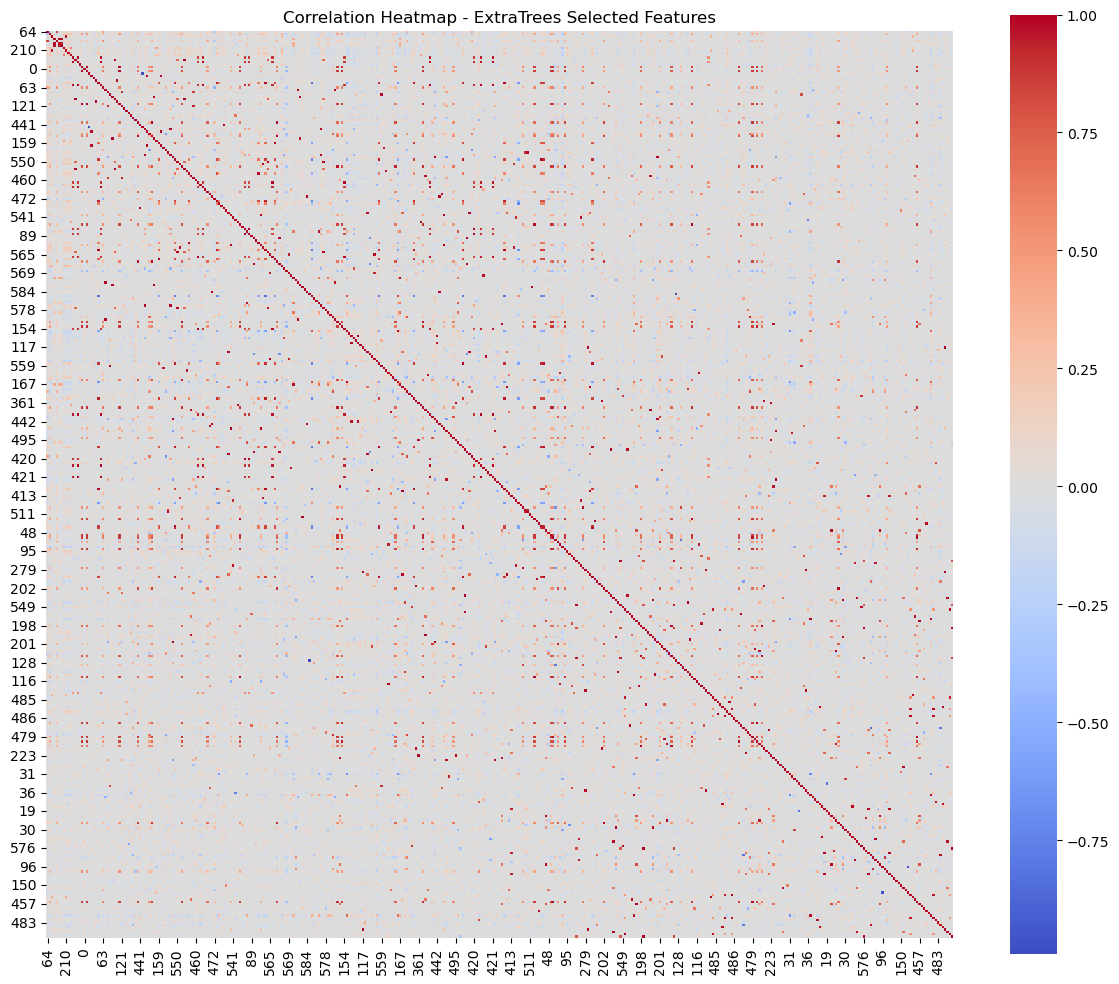

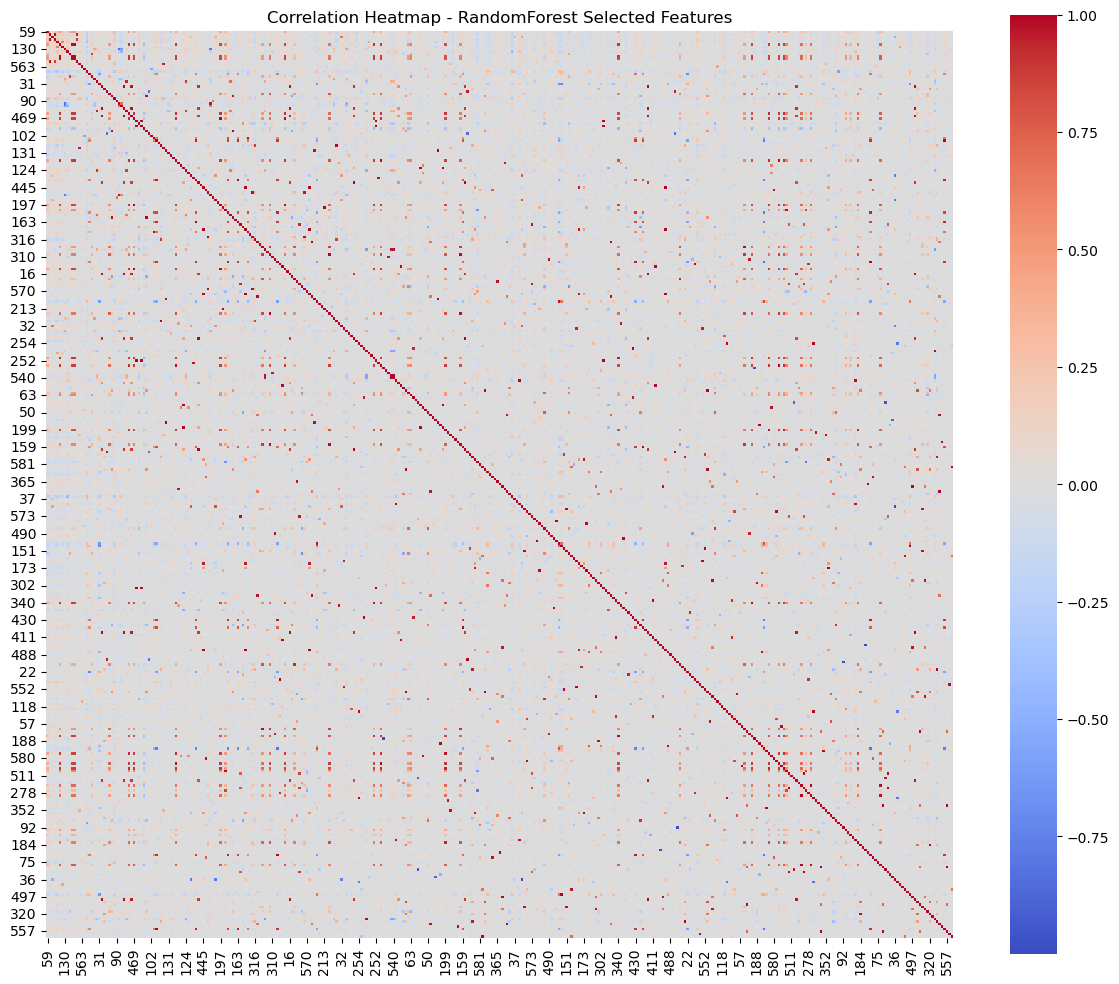

In [11]:
# Remove target column before correlation
et_corr = et_df.drop(columns='Pass/Fail').corr()
rf_corr = rf_df.drop(columns='Pass/Fail').corr()

# === ExtraTrees correlation heatmap ===
plt.figure(figsize=(12, 10))
sns.heatmap(et_corr, cmap='coolwarm', center=0, square=True)
plt.title("Correlation Heatmap - ExtraTrees Selected Features")
plt.tight_layout()
plt.show()

# === RandomForest correlation heatmap ===
plt.figure(figsize=(12, 10))
sns.heatmap(rf_corr, cmap='coolwarm', center=0, square=True)
plt.title("Correlation Heatmap - RandomForest Selected Features")
plt.tight_layout()
plt.show()

In [12]:
# Function to drop highly correlated features
def drop_highly_correlated(df, threshold=0.95):
    X = df.drop(columns='Pass/Fail')
    y = df['Pass/Fail']
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"Dropping {len(to_drop)} highly correlated features (correlation > {threshold})")
    reduced_df = X.drop(columns=to_drop)
    reduced_df['Pass/Fail'] = y
    return reduced_df

# Clean versions of your selected feature sets
et_df_uncorr = drop_highly_correlated(et_df, threshold=0.9)
rf_df_uncorr = drop_highly_correlated(rf_df, threshold=0.9)

# Without most important feature 
et_df_no_top_4_uncorr = drop_highly_correlated(et_df_no_top_4, threshold=0.9)
rf_df_no_top_4_uncorr = drop_highly_correlated(rf_df_no_top_4, threshold=0.9)

Dropping 163 highly correlated features (correlation > 0.9)
Dropping 140 highly correlated features (correlation > 0.9)
Dropping 161 highly correlated features (correlation > 0.9)
Dropping 139 highly correlated features (correlation > 0.9)


In [14]:
# Function to apply PCA to any feature set (excluding target)
def apply_pca(df, variance_threshold=0.90):
    X_sel = df.drop(columns='Pass/Fail').values
    y_sel = df['Pass/Fail'].values
    pca = PCA(n_components=variance_threshold, random_state=42)
    X_pca = pca.fit_transform(X_sel)
    print(f"PCA reduced from {X_sel.shape[1]} to {X_pca.shape[1]} components to preserve {variance_threshold*100:.0f}% variance.")
    pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
    pca_df['Pass/Fail'] = y_sel
    return pca_df

In [15]:
# PCA on correlated feature sets
et_pca_df = apply_pca(et_df)
rf_pca_df = apply_pca(rf_df)

# PCA on de-correlated feature sets
et_pca_uncorr_df = apply_pca(et_df_uncorr)
rf_pca_uncorr_df = apply_pca(rf_df_uncorr)

# PCA on correlated features without the most important
et_pca_no_top_4_df = apply_pca(et_df_no_top_4)
rf_pca_no_top_4_df = apply_pca(rf_df_no_top_4)

# PCA on de-correlated features without the most important
et_pca_no_top_4_uncorr_df = apply_pca(et_df_no_top_4_uncorr)
rf_pca_no_top_4_uncorr_df = apply_pca(rf_df_no_top_4_uncorr)

PCA reduced from 391 to 121 components to preserve 90% variance.
PCA reduced from 367 to 122 components to preserve 90% variance.
PCA reduced from 228 to 128 components to preserve 90% variance.
PCA reduced from 227 to 128 components to preserve 90% variance.
PCA reduced from 387 to 121 components to preserve 90% variance.
PCA reduced from 363 to 121 components to preserve 90% variance.
PCA reduced from 226 to 128 components to preserve 90% variance.
PCA reduced from 224 to 127 components to preserve 90% variance.


In [ ]:
splits = {}

def split_data(df, name, test_size=0.2, random_state=42):
    X = df.drop(columns='Pass/Fail').values
    y = df['Pass/Fail'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    splits[name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

    print(f"[{name}]: Train: {X_train.shape}, Test: {X_test.shape}, Class balance (train): {np.bincount(y_train)}, (test): {np.bincount(y_test)}")


In [17]:
split_data(et_df, "ET_raw")
split_data(rf_df, "RF_raw")
split_data(et_df_uncorr, "ET_uncorr")
split_data(rf_df_uncorr, "RF_uncorr")
split_data(et_pca_df, "ET_PCA")
split_data(rf_pca_df, "RF_PCA")
split_data(et_pca_uncorr_df, "ET_PCA_uncorr")
split_data(rf_pca_uncorr_df, "RF_PCA_uncorr")

[ET_raw]: Train: (1253, 391), Test: (314, 391), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_raw]: Train: (1253, 367), Test: (314, 367), Class balance (train): [  83 1170], (test): [ 21 293]
[ET_uncorr]: Train: (1253, 228), Test: (314, 228), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_uncorr]: Train: (1253, 227), Test: (314, 227), Class balance (train): [  83 1170], (test): [ 21 293]
[ET_PCA]: Train: (1253, 121), Test: (314, 121), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_PCA]: Train: (1253, 122), Test: (314, 122), Class balance (train): [  83 1170], (test): [ 21 293]
[ET_PCA_uncorr]: Train: (1253, 128), Test: (314, 128), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_PCA_uncorr]: Train: (1253, 128), Test: (314, 128), Class balance (train): [  83 1170], (test): [ 21 293]


In [18]:
split_data(et_df_no_top_4, "ET_NO_top_4")
split_data(rf_df_no_top_4, "RF_NO_top_4")
split_data(et_df_no_top_4_uncorr, "ET_NO_top_4_uncorr")
split_data(rf_df_no_top_4_uncorr, "RF_NO_top_4_uncorr")
split_data(et_pca_no_top_4_df, "ET_PCA_NO_top_4")
split_data(rf_pca_no_top_4_df, "RF_PCA_NO_top_4")
split_data(et_pca_no_top_4_uncorr_df, "ET_PCA_NO_top_4_uncorr")
split_data(rf_pca_no_top_4_uncorr_df, "RF_PCA_NO_top_4_uncorr")


[ET_NO_top_4]: Train: (1253, 387), Test: (314, 387), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_NO_top_4]: Train: (1253, 363), Test: (314, 363), Class balance (train): [  83 1170], (test): [ 21 293]
[ET_NO_top_4_uncorr]: Train: (1253, 226), Test: (314, 226), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_NO_top_4_uncorr]: Train: (1253, 224), Test: (314, 224), Class balance (train): [  83 1170], (test): [ 21 293]
[ET_PCA_NO_top_4]: Train: (1253, 121), Test: (314, 121), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_PCA_NO_top_4]: Train: (1253, 121), Test: (314, 121), Class balance (train): [  83 1170], (test): [ 21 293]
[ET_PCA_NO_top_4_uncorr]: Train: (1253, 128), Test: (314, 128), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_PCA_NO_top_4_uncorr]: Train: (1253, 127), Test: (314, 127), Class balance (train): [  83 1170], (test): [ 21 293]


In [ ]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42),
    'DecisionTree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'GaussianNB': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(probability=True, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=12, random_state=42)
}

# Dictionary to store CV results
cv_results = {}

def run_cross_validation(dataset_name, cv_folds=7):
    data = splits[dataset_name]
    X, y = data['X_train'], data['y_train']

    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    results = []

    for name, model in models.items():
        print(f"Training {name} on {dataset_name}...")

        scores = cross_validate(
            model, X, y,
            cv=skf,
            scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
            return_train_score=False,
            n_jobs=-1
        )

        results.append({
            'Model': name,
            'Dataset': dataset_name,
            'Accuracy':  scores['test_accuracy'].mean(),
            'Precision': scores['test_precision'].mean(),
            'Recall':    scores['test_recall'].mean(),
            'F1 Score':  scores['test_f1'].mean(),
            'ROC AUC':   scores['test_roc_auc'].mean(),
            'Fit Time':  scores['fit_time'].mean()
        })

    # Save to global results dictionary
    cv_results[dataset_name] = pd.DataFrame(results)
    print(f"\nCross-validation completed for {dataset_name}\n")


In [ ]:
for dataset_name in splits.keys():
    run_cross_validation(dataset_name)

In [ ]:
# Aggregate across datasets
all_cv_df = pd.concat(cv_results.values(), ignore_index=True)

# Define consistent dataset order
ordered_datasets = [
    "ET_raw", "ET_uncorr", "ET_PCA", "ET_PCA_uncorr",
    "RF_raw", "RF_uncorr", "RF_PCA", "RF_PCA_uncorr",
    "ET_NO_top_4", "ET_NO_top_4_uncorr", "ET_PCA_NO_top_4", "ET_PCA_NO_top_4_uncorr",
    "RF_NO_top_4", "RF_NO_top_4_uncorr", "RF_PCA_NO_top_4", "RF_PCA_NO_top_4_uncorr"
]
ordered_datasets = [ds for ds in ordered_datasets if ds in all_cv_df['Dataset'].unique()]

# Target group
target_datasets = [
    "ET_NO_top_4", "RF_NO_top_4",
    "ET_NO_top_4_uncorr", "RF_NO_top_4_uncorr",
    "ET_PCA_NO_top_4", "RF_PCA_NO_top_4",
    "ET_PCA_NO_top_4_uncorr", "RF_PCA_NO_top_4_uncorr"
]

In [ ]:
# Filter only the RF_raw and RF_uncorr datasets
rf_df = all_cv_df[all_cv_df['Dataset'].isin(['RF_raw', 'RF_uncorr'])]

# Pivot so models are rows and datasets are columns
rf_pivot = rf_df.pivot(index='Model', columns='Dataset', values='Fit Time')

# Sort by RF_raw times for consistency
rf_pivot_sorted = rf_pivot.sort_values(by='RF_raw', ascending=True)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Plot RF_raw ---
axes[0].barh(rf_pivot_sorted.index, rf_pivot_sorted['RF_raw'], color='steelblue')
axes[0].set_title("Training Time — RF_raw - (1567 rows X 590 columns)")
axes[0].set_xlabel("Fit Time (seconds)")
for i, v in enumerate(rf_pivot_sorted['RF_raw']):
    axes[0].text(v, i, f"{v:.2f}", va='center', ha='left', fontsize=9)

# --- Plot RF_uncorr ---
axes[1].barh(rf_pivot_sorted.index, rf_pivot_sorted['RF_uncorr'], color='orange')
axes[1].set_title(f"Training Time — RF_uncorr - (1567 rows X 228 columns)")
axes[1].set_xlabel("Fit Time (seconds)")
for i, v in enumerate(rf_pivot_sorted['RF_uncorr']):
    axes[1].text(v, i, f"{v:.2f}", va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
def plot_metric_heatmaps(metric='F1 Score', cmap='YlGnBu'):
    combined = pd.concat(cv_results.values(), ignore_index=True)

    pivot_target = combined[combined['Dataset'].isin(target_datasets)] \
        .pivot(index='Model', columns='Dataset', values=metric) \
        .reindex(columns=[ds for ds in ordered_datasets if ds in target_datasets])
    
    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(pivot_target, annot=True, fmt=".2f", cmap=cmap)
    plt.title(f'{metric} — No top 4 Datasets')
    plt.tight_layout()
    plt.show()


    pivot_other = combined[~combined['Dataset'].isin(target_datasets)] \
        .pivot(index='Model', columns='Dataset', values=metric) \
        .reindex(columns=[ds for ds in ordered_datasets if ds not in target_datasets])
    
    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(pivot_other, annot=True, fmt=".2f", cmap=cmap)
    plt.title(f'{metric} — Other Datasets')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_metric_heatmaps('F1 Score')
plot_metric_heatmaps('ROC AUC')


In [ ]:
def plot_top3_roc_subplots(dataset_name, cv_folds=7, splitter=None):
    if dataset_name not in cv_results:
        raise KeyError(f"{dataset_name} not found in cv_results. Run run_cross_validation('{dataset_name}') first.")

    top3 = (cv_results[dataset_name]
            .sort_values(by='ROC AUC', ascending=False)
            .head(3)
            .reset_index(drop=True))

    data = splits[dataset_name]
    X, y = data['X_train'], data['y_train']

    # make sure indexing works for pandas or numpy
    def _split(idx):
        if hasattr(X, "iloc"):
            return X.iloc[idx], y.iloc[idx]
        return X[idx], y[idx]

    # use identical CV config as run_cross_validation
    skf = splitter if splitter is not None else StratifiedKFold(
        n_splits=cv_folds, shuffle=True, random_state=42
    )

    mean_fpr = np.linspace(0, 1, 200)

    n_models = len(top3)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5), sharex=True, sharey=True)
    if n_models == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, top3.iterrows()):
        model_name = row['Model']
        base_model = models[model_name]
        model = clone(base_model)

        tprs = []
        aucs = []

        # to ensure displayed AUC matches cv_results exactly, compute via cross_val_score
        # (same splitter, same scoring)
        cv_auc = cross_val_score(model, X, y, cv=skf, scoring='roc_auc').mean()

        # also build a mean ROC curve across the same folds
        for train_idx, val_idx in skf.split(X, y):
            X_tr, y_tr = _split(train_idx)
            X_val, y_val = _split(val_idx)

            model.fit(X_tr, y_tr)
            # mirror sklearn scoring logic: predict_proba if available else decision_function
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(X_val)[:, 1]
            elif hasattr(model, "decision_function"):
                y_score = model.decision_function(X_val)
            else:
                # fallback (rare): use predict() as scores; AUC may degrade
                y_score = model.predict(X_val)

            fpr, tpr, _ = roc_curve(y_val, y_score)
            interp = np.interp(mean_fpr, fpr, tpr)
            interp[0] = 0.0
            tprs.append(interp)
            aucs.append(auc(fpr, tpr))

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        ax.plot(mean_fpr, mean_tpr, lw=2)
        ax.plot([0, 1], [0, 1], linestyle='--', lw=1)
        ax.set_title(f"{dataset_name} — {model_name}\nAUC = {cv_auc:.3f}")
        ax.set_xlim(0.0, 1.0)
        ax.set_ylim(0.0, 1.05)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.grid(True, alpha=0.3)

    fig.suptitle(f"Top 3 Mean ROC Curves — {dataset_name}", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()


In [ ]:
for name in splits.keys():
    plot_top3_roc_subplots(name)

In [ ]:
times = []
threads = [1,2,4,6,8]

df_duplicated = pd.concat([df for _ in range(100)], ignore_index=True)
print(df_duplicated.shape)

X,y = df_duplicated.drop(columns=['Pass/Fail','Time']), df_duplicated['Pass/Fail']
for t in threads:
    print(f"Start training on {t} threads")
    model = XGBClassifier(n_estimators=200, tree_method="hist", n_jobs=t)
    start = time.time()
    model.fit(X, y)
    times.append(time.time() - start)
    print(f"Finished on {t} threads")
    if(t in [1,2,4,6]):
        time.sleep(30)
    else:
        time.sleep(5)


In [ ]:
plt.figure(figsize=(12, 6))
positions = range(len(threads))
plt.bar(positions, times, width=0.6)
for i, t_val in enumerate(times):
    plt.text(i, t_val, f"{t_val:.2f}", ha="center", va="bottom")

plt.xticks(positions, threads)
plt.xlabel("Threads")
plt.ylabel("Training Time (s)")
plt.title("XGBoost Training Time — Multiple Threads - (156700 rows X 592 columns)")
plt.show()


In [ ]:
threads = [1,2,4,8]
df_duplicated = pd.concat([df for _ in range(100)], ignore_index=True)
print(df_duplicated.shape)

X_full,y = df_duplicated.drop(columns=['Pass/Fail','Time']), df_duplicated['Pass/Fail']
print(X_full.shape)

results = {t: [] for t in threads}

n_cols= [50,100,200,300,400,500,590]
for n in n_cols:
    X = X_full.iloc[:,:n]
    for t in threads:
        print(f"Start training on {t} threads")
        model = XGBClassifier(n_estimators=200, tree_method="hist", n_jobs=t)
        start = time.time()
        model.fit(X, y)
        results[t].append(time.time() - start)
        print(f"Finished on {t} threads")
        time.sleep(10)

In [ ]:
plt.figure(figsize=(12, 6))
for t in threads:
    plt.plot(n_cols, results[t], marker='o', label=f'{t} threads')

plt.xlabel("Number of Columns")
plt.ylabel("Training Time (s)")
plt.title(f"XGBoost Training Time vs. Feature Count — {X_full.shape[0]} rows × up to {X_full.shape[1]} columns")
plt.legend(title="Threads")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [39]:
threads = [1,2,4]

results = {t: [] for t in threads}

n_rows= [10,20,50,100,200,300]
for n in n_rows:
    df_duplicated = pd.concat([df for _ in range(n)], ignore_index=True)
    X,y = df_duplicated.drop(columns=['Pass/Fail','Time']), df_duplicated['Pass/Fail']
    for t in threads:
        print(f"Start training on {t} threads - {X.shape[0]} rows")
        model = XGBClassifier(n_estimators=200, tree_method="hist", n_jobs=t)
        start = time.time()
        model.fit(X, y)
        results[t].append(time.time() - start)
        print(f"    Finished on {t} threads - {X.shape[0]} rows")
        time.sleep(10)

Start training on 2 threads - 78350 rows
    Finished on 2 threads - 78350 rows
Start training on 4 threads - 78350 rows


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 6))
for t in threads:
    plt.plot(np.multiply(n_rows,1570), results[t], marker='o', label=f'{t} threads')

plt.xlabel("Number of Rows")
plt.ylabel("Training Time (s)")
plt.title(f"XGBoost Training Time vs. Rows Count — up to {n_rows[-1]*1570} rows × {X_full.shape[1]} columns")
plt.legend(title="Threads")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [30]:
import joblib
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=12,
    random_state=42
)

# Data
data = splits["RF_uncorr"]
X, y = data['X_train'], data['y_train']

# Cross-validation setup
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

# Evaluate with cross-validation
scores = cross_validate(model, X, y, cv=cv, scoring=['f1','roc_auc'])

print("CV Scores:", scores)

# Fit on the full training data (after CV)
model.fit(X, y)

# Save final trained model
joblib.dump(model, "../models/xgb_model.pkl")
print("Model saved to xgb_model.pkl")

c:\Users\Abdullah\miniconda3\envs\classification_problem\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:48:05] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\miniconda3\envs\classification_problem\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:48:06] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\miniconda3\envs\classification_problem\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:48:07] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\miniconda3\envs\classification_problem\Lib\site-packages\x

CV Scores: {'fit_time': array([0.96320176, 0.88568664, 0.85779071, 0.83314681, 0.81780052,
       0.81037807, 0.8381753 ]), 'score_time': array([0.01299024, 0.01224017, 0.01299906, 0.01161075, 0.01271605,
       0.01036477, 0.00983   ]), 'test_f1': array([0.96829971, 0.96531792, 0.96811594, 0.96531792, 0.96531792,
       0.96531792, 0.96531792]), 'test_roc_auc': array([0.69426407, 0.76546906, 0.71057884, 0.6751497 , 0.66816367,
       0.86177645, 0.77145709])}


c:\Users\Abdullah\miniconda3\envs\classification_problem\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:48:11] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model saved to xgb_model.pkl


In [26]:
model = joblib.load("../models/xgb_model.pkl")

In [33]:
print(scores['test_f1'].mean())
print(scores['test_roc_auc'].mean())

0.9661436070314673
0.7352655542347587


In [34]:
model.predict(data['X_test'])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,